# ADA - Final notebook

This notebook contains all the code which has been used to generate the plots and figures of our [datastory](https://antoineweber.github.io/ADA_Project_RobAda/).

As a summary, our goal was to investigate the potential difference between organic/bio products and regular ones, based on the [Open Food Facts](https://ch-en.openfoodfacts.org/data) dataset.

**TODO:** Add table of content. (Tkt Lucas avec mon extension jupyter j'ai juste a cliquer un bouton, pas besoin d'écrire 20 lignes a la main)

## Imports

In [1]:
import pickle
import pprint
import time
import sys
import os
import json
import copy
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

import plotly
from plotly import graph_objs as go, tools
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from math import pi

# We generate the interactive plots with Altair
import altair as alt

## Loading the dataset

In [2]:
# Make sure to download the dataset and place it in the data folder
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

code                                                url  \
0         0000000000017  http://world-en.openfoodfacts.org/product/0000...   
1         0000000000031  http://world-en.openfoodfacts.org/product/0000...   
2    000000000003327986  http://world-en.openfoodfacts.org/product/0000...   
3         0000000000100  http://world-en.openfoodfacts.org/product/0000...   
4  00000000001111111111  http://world-en.openfoodfacts.org/product/0000...   

                      creator   created_t      created_datetime  \
0                     kiliweb  1529059080  2018-06-15T10:38:00Z   
1                    isagoofy  1539464774  2018-10-13T21:06:14Z   
2                     kiliweb  1574175736  2019-11-19T15:02:16Z   
3                       del51  1444572561  2015-10-11T14:09:21Z   
4  openfoodfacts-contributors  1560020173  2019-06-08T18:56:13Z   

   last_modified_t last_modified_datetime                  product_name  \
0       1561463718   2019-06-25T11:55:18Z              Vitória crackers   
1       1539464817   2018-10-13T21:06:57Z                         Cacao   
2       1574175737   2019-11-19T15:02:17Z     Filetes de pollo empanado   
3       1444659212   2015-10-12T14:13:32Z   moutarde au moût de raisin    
4       1560020173   2019-06-08T18:56:13Z                       Sfiudwx   

  generic_name quantity  ... carbon-footprint-from-meat-or-fish_100g  \
0          NaN      NaN  ...                                     NaN   
1          NaN    130 g  ...                                     NaN   
2          NaN      NaN  ...                                     NaN   
3          NaN     100g  ...                                     NaN   
4          NaN    dgesc  ...                                     NaN   

  nutrition-score-fr_100g nutrition-score-uk_100g glycemic-index_100g  \
0                     NaN                     NaN                 NaN   
1                     NaN                     NaN                 NaN   
2                     NaN                     NaN                 NaN   
3                    18.0                    18.0                 NaN   
4                     NaN                     NaN                 NaN   

  water-hardness_100g choline_100g phylloquinone_100g beta-glucan_100g  \
0                 NaN          NaN                NaN              NaN   
1                 NaN          NaN                NaN              NaN   
2                 NaN          NaN                NaN              NaN   
3                 NaN          NaN                NaN              NaN   
4                 NaN          NaN                NaN              NaN   

  inositol_100g carnitine_100g  
0           NaN            NaN  
1           NaN            NaN  
2           NaN            NaN  
3           NaN            NaN  
4           NaN            NaN  

[5 rows x 177 columns]

In [3]:
print("There are {} rows, hence products, in the dataset.".format(food_facts_df.shape[0]))
print("There are {} columns, hence fields, in the dataset.".format(food_facts_df.shape[1]))

There are 1051145 rows, hence products, in the dataset.
There are 177 columns, hence fields, in the dataset.


### Available fields <a class="anchor" id="availablefields"></a> 

The dataset description is available [here](https://static.openfoodfacts.org/data/data-fields.txt).

This dataset is provided with a text file describing the different fields. We present a brief overview of the main types of fields:

* field `code` containing the product's code. 
* field `creator` indicating who added the product to the dataset. 
* field `countries` showing where the product is selled. 
* fields that end with `_t` are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
* fields that end with `_datetime` are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
* fields that end with `_tags` are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
* fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
* fields that end with `_100g` correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
* fields that end with `_serving` correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

**TODO:** Add general cleaning part if it is still necessary

## Bio vs. regular products

A lot of products claim to be bio. Different terms are used depending on the location (organic, bio, ...), but overall they all refer to the same fact that the product was mostly produced in compliance with the standards of [organic farming](https://en.wikipedia.org/wiki/Organic_farming). In the common knowledge, people often claim that organic or bio products are healthier than non-organic products.

In the upcoming analysis, we will try to investigate whether this statement is quantitavely true or if sometimes companies take advantage of the "bio" acronym to gain market shares.

We will conduct this analysis by investigating different columns of interest: 

* We have access to two different nutritional scores. We will try to investigate whether differences can be observed with respect to this column, i.e if bio/organic products tend to obtain better nutritional scores than standard products.
    - In addition, some bio products may obtain bad nutritional scores. We will try to pinpoint why some bio products would still get such bad scores.
    
    
* As stated above, organic products should undergo as little tratment as possible, inducing a more natural product. This should directly be represented by a lower capacity in additives. Hence as a first step we will assess whether there is a different in additives between bio and normal products.

### Extracting organic/bio products

Some product contain words such as 'bio', 'biologic', 'organic' in their `product_name`, so this can be use to distinguish them from normal products. In addition, the dataset contains the columns `labels`, `labels_tags` and `labels_en`, which contain information about quality labels/certifications which also include bio products.

Thus, these columns can be used to split the dataset into 'bio' products and regular products. We will seach for keywords in these columns to determine if a product is bio:

In [4]:
bio_keywords = ['bio', 'organi'] # bio --> bio, biological, biologique, etc.; organi --> organic, organique

contains_bio_keywords = lambda x: any([(kw in str(x)) for kw in bio_keywords])

Let's add a new boolean column to the dataframe, to specify is the product is organic:

In [5]:
# Check for products matching the bio keywords in the 4 columns
bio_products = (food_facts_df['product_name'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_tags'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_en'].apply(contains_bio_keywords))

food_facts_df['bio'] = bio_products

print('There are {} bio products, and {} non-bio products.'.format(food_facts_df['bio'].sum(), 
                                                len(food_facts_df['bio']) - food_facts_df['bio'].sum()))
food_facts_df[food_facts_df['bio'] == True].head(5)

There are 74434 bio products, and 976711 non-bio products.


code                                                url  \
20  0000000001427  http://world-en.openfoodfacts.org/product/0000...   
41   000000000429  http://world-en.openfoodfacts.org/product/0000...   
66   000000001011  http://world-en.openfoodfacts.org/product/0000...   
88  0000000014595  http://world-en.openfoodfacts.org/product/0000...   
97  0000000016087  http://world-en.openfoodfacts.org/product/0000...   

            creator   created_t      created_datetime  last_modified_t  \
20          kiliweb  1550231727  2019-02-15T11:55:27Z       1550231732   
41          kiliweb  1567080029  2019-08-29T12:00:29Z       1567080749   
66          kiliweb  1568142714  2019-09-10T19:11:54Z       1568143389   
88          kiliweb  1520321992  2018-03-06T07:39:52Z       1561463802   
97  usda-ndb-import  1489055731  2017-03-09T10:35:31Z       1545997008   

   last_modified_datetime                                    product_name  \
20   2019-02-15T11:55:32Z                                Pain de maïs bio   
41   2019-08-29T12:12:29Z                                   Jus de Pommes   
66   2019-09-10T19:23:09Z  Fromage blanc fermier de chèvre au lait entier   
88   2019-06-25T11:56:42Z                            Pâte de fruit fraise   
97   2018-12-28T11:36:48Z                          Organic Salted Nut Mix   

   generic_name quantity  ... nutrition-score-fr_100g nutrition-score-uk_100g  \
20          NaN      NaN  ...                     NaN                     NaN   
41          NaN      NaN  ...                     NaN                     NaN   
66          NaN      NaN  ...                     NaN                     NaN   
88          NaN      NaN  ...                     NaN                     NaN   
97          NaN      NaN  ...                     NaN                     NaN   

   glycemic-index_100g water-hardness_100g choline_100g phylloquinone_100g  \
20                 NaN                 NaN          NaN                NaN   
41                 NaN                 NaN          NaN                NaN   
66                 NaN                 NaN          NaN                NaN   
88                 NaN                 NaN          NaN                NaN   
97                 NaN                 NaN          NaN                NaN   

   beta-glucan_100g inositol_100g carnitine_100g   bio  
20              NaN           NaN            NaN  True  
41              NaN           NaN            NaN  True  
66              NaN           NaN            NaN  True  
88              NaN           NaN            NaN  True  
97              NaN           NaN            NaN  True  

[5 rows x 178 columns]

We now have a new column in our dataset indicating whether products are organic or regular.

## Categorical analysis

Since there is a different representation of product categories between regular and organic products, balancing the datasets as much as possible is essential to provide insightful information regarding both categories. This was the main shortcomming of milestone 2 and this is adressed here.

For our analysis, we want to compare organic and regular products in terms of **nutrional score**, **contained additives**, **nova groups** and more. However, as shown in the previous section we have two highly unbalanced classes, as there are much fewer organic products. In addition to this, we don't know if the distribution of product categories is different between the regular and organic data. For instance, it could be possible that for organic products there are much more juices than other types of products.

In order to provide a more rigourous analysis, we will try to split the dataset into different categories, and then perform a comparative analysis in each category

### Determining the categories of products in the dataset

The open food facts dataset contains several columns representing the categories : **TODO: list the columns**. The column that is most present is `categories_en`. It is composed of a set of categories separated by commas. In addition, there are some metadata inside it to specify the language of the keywords, such `en:` and `fr:` for english and french respectively.

Our goal is to find out which categories are actually present in `categories_en`. Then we can find common categories to split the dataset based on keywords. For instance, if we wanted to find all the dairy products, we could look for the keywords `[milk, cheese, yoghurt]` in `categories_en`. 

We can also look for keywords related to the category in the `product_name` column. However, it would be more difficult to obtain a reliable splitting. Indeed, if we had a product named `goat milk`, it could be classified in the `meat` category since its name contains `goat`, whereas it's `categories_en` columns would not have `meat` in it. For this reason, we use only the `categories_en` column. **TODO: maybe check with both columns**

In [6]:
# Get the relevant column from the dataset
categories_df = food_facts_df[['categories_en']].dropna().copy()
categories_df.head(5)

categories_en
3                Groceries,Condiments,Sauces,Mustards
4                                              fr:xsf
10  Meals,Prepared vegetables,Grated carrots,Seaso...
17                       Pies,Sweet pies,Coconut pies
25  Plant-based foods and beverages,Plant-based fo...

Our goal is to identify the most common words describing the categories of products across the dataset. 

We use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to build a bag of words from `categories_en`.

We leverage the arguments of the class to transform all the words to lowercase, ignore stopwords and perform character normalization (remove accents, etc.). In addition, we discard the words that have less than **50** occurences.

In [7]:
def strip_accents(words):
    """ Remove accents in a list of words. """
    
    # If words is [], None or similar
    if not words:
        return words 
    
    # We use the CountVectorizer to actually remove accents
    vectorizer = CountVectorizer(lowercase=False, strip_accents='ascii')
    vectorizer.fit_transform(words)
    
    return vectorizer.get_feature_names()

# We use the stopwords from nltk (uncomment following 2 lines to download the keywords)
#import nltk 
#nltk.download('stopwords') 
from nltk.corpus import stopwords

# We need french+english stopwords as there are both languages in the column
stop_words = stopwords.words('english')
stop_words.extend(strip_accents(stopwords.words('french')))

# These labels is present in the column to signify french/english categories
stop_words.append('fr')
stop_words.append('en')

# Remove dupplicates if any
stop_words = list(set(stop_words))

# Discard categories that are too rare 
min_occurences = 50

vectorizer = CountVectorizer(stop_words=stop_words, lowercase=True, 
                             strip_accents='ascii', min_df=min_occurences)

bag = vectorizer.fit_transform(categories_df['categories_en'].values)
bag_features = vectorizer.get_feature_names()
print('There are {} different words in total.'.format(len(bag_features)))
print('Keywords:', bag_features[:10]) 

There are 1715 different words in total.
Keywords: ['10', '12', '18', '2000', '2012', '2013', 'ab', 'abbey', 'abondance', 'abricot']


Let's find out the most common words:

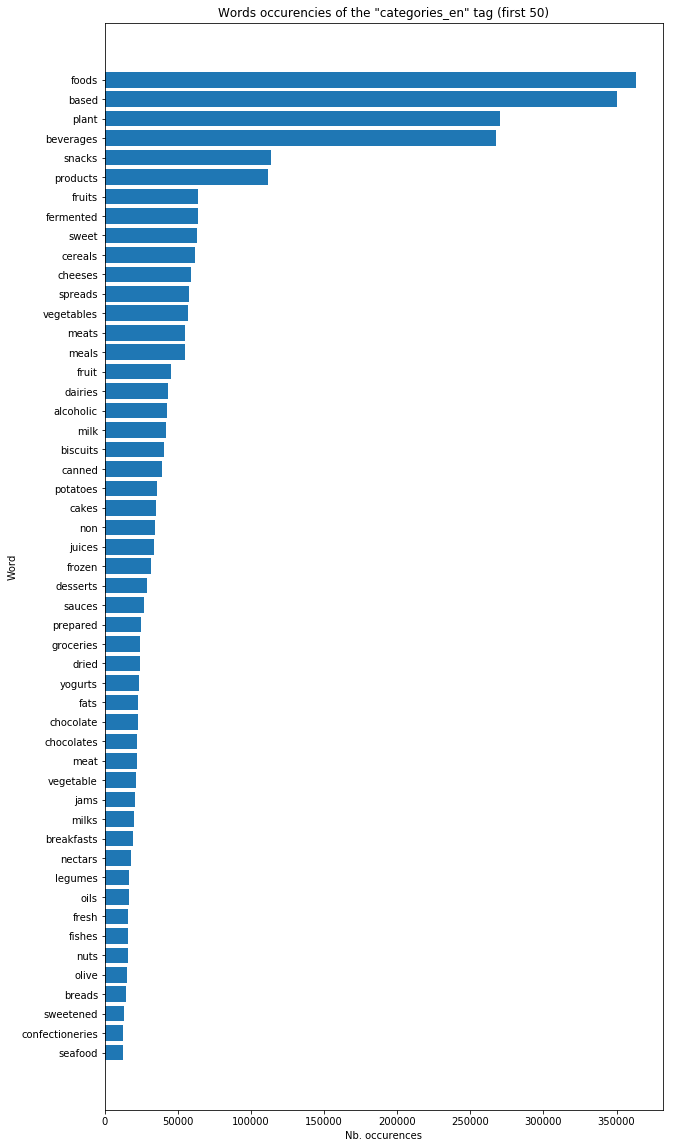

In [8]:
# Sum along the columns to get the total number of occurencies of each token
words_occurences = np.array(bag.sum(axis=0))[0]

# Build a dataframe with the words occurencies
words_occurencies_df = pd.DataFrame({'word':bag_features,'count':words_occurences}).sort_values(by=['count'],ascending=False)\
                            .reset_index().drop(columns='index')

# Plot the most common words
n = 50
plt.figure(figsize=(10,20))
plt.barh(words_occurencies_df.loc[0:n]['word'].values[::-1],
         words_occurencies_df.loc[0:n]['count'].values[::-1])
plt.title('Words occurencies of the "categories_en" tag (first {})'.format(n))
plt.ylabel('Word')
plt.xlabel('Nb. occurences')
plt.show()

There is a good list of words that can be used for categories, although some of them are too general, for instance the most common ones which are `foods` and `based`.

Let's clean the column `categories_en` using the same pre-processing and stop-words removal as before:

In [9]:
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

categories_df['categories_en'] = categories_df['categories_en'].apply(preprocessor).apply(tokenizer)\
                                    .apply(lambda words: ' '.join([w for w in words if w not in stop_words]))
categories_df.head(5)

categories_en
3                groceries condiments sauces mustards
4                                                 xsf
10  meals prepared vegetables grated carrots seaso...
17                       pies sweet pies coconut pies
25  plant based foods beverages plant based foods ...

We can now define a function that can be used to obtain the product that belong to a specific category defined by keywords:

In [10]:
def find_products_from_category(raw_df, pre_processed_df, category_keywords):
    """ Obtain the products that fall in a given category.
    
    A product belong to a category if its column `categories_en` contain
    one of the category_keywords.
    
    Args:
        raw_df: raw Open Food Facts dataframe to be able to fetch all the products information
        pre_processed_df: datframe where the columns `categories_en` have been
                          cleaned of stopwords, case, accents, etc.
        category_keywords: List of keywords to find in `categories_en`. Note that since the
                           pre_processed_df is a clean string, there is no need to include
                           variations such as `cheese` and `cheeses`, a common step is enough.
        
    Return:
        The products that belong to the categories, with all the info from raw_df
    
    """
    
    products = pre_processed_df[pre_processed_df['categories_en'].apply(
                lambda x : any(kw in x for kw in category_keywords))]
    
    return raw_df.loc[products.index]

For instance let's obtain the dairy products:

In [11]:
dairy_kw = ['dairies','milk','cheese']
dairy_df = find_products_from_category(food_facts_df, categories_df, category_keywords=dairy_kw)
print('There are {} dairy products.'.format(dairy_df.shape[0]))
dairy_df.head(10)

There are 51372 dairy products.


code                                                url  \
51    0000000005005  http://world-en.openfoodfacts.org/product/0000...   
319   0000000491228  http://world-en.openfoodfacts.org/product/0000...   
763   0000405017511  http://world-en.openfoodfacts.org/product/0000...   
1004  0000939333330  http://world-en.openfoodfacts.org/product/0000...   
1080       00011747  http://world-en.openfoodfacts.org/product/0001...   
1089  0001200001217  http://world-en.openfoodfacts.org/product/0001...   
1117       00013029  http://world-en.openfoodfacts.org/product/0001...   
1221  0002000000707  http://world-en.openfoodfacts.org/product/0002...   
1222  0002000000714  http://world-en.openfoodfacts.org/product/0002...   
1238  0002000001698  http://world-en.openfoodfacts.org/product/0002...   

              creator   created_t      created_datetime  last_modified_t  \
51            kiliweb  1521663684  2018-03-21T20:21:24Z       1545934272   
319           kiliweb  1543690964  2018-12-01T19:02:44Z       1543692731   
763           kiliweb  1551706268  2019-03-04T13:31:08Z       1552159083   
1004           emoups  1569696676  2019-09-28T18:51:16Z       1569697074   
1080         teolemon  1424634361  2015-02-22T19:46:01Z       1561464979   
1089  date-limite-app  1534008219  2018-08-11T17:23:39Z       1545929001   
1117          beniben  1494672859  2017-05-13T10:54:19Z       1494674596   
1221          kiliweb  1536492887  2018-09-09T11:34:47Z       1569853724   
1222          kiliweb  1518439760  2018-02-12T12:49:20Z       1552560002   
1238          kiliweb  1549132328  2019-02-02T18:32:08Z       1552569293   

     last_modified_datetime                            product_name  \
51     2018-12-27T18:11:12Z                               Abondance   
319    2018-12-01T19:32:11Z                  Entremets Crème Brulée   
763    2019-03-09T19:18:03Z                       Chaource lait cru   
1004   2019-09-28T18:57:54Z                           creme fraiche   
1080   2019-06-25T12:16:19Z  Triple Belgian Chocolaté Chunk Cookies   
1089   2018-12-27T16:43:21Z                                   comte   
1117   2017-05-13T11:23:16Z                                 Cheddar   
1221   2019-09-30T14:28:44Z                  Camenbert de Normandie   
1222   2019-03-14T10:40:02Z                    Yaourt nature brebis   
1238   2019-03-14T13:14:53Z     Yaourt au lait de brebis bio Nature   

             generic_name                 quantity  ...  \
51                    NaN                      NaN  ...   
319                   NaN                     20 g  ...   
763                   NaN                      NaN  ...   
1004                  NaN              213g, 7.5OZ  ...   
1080                  NaN                  225 g e  ...   
1089                  NaN                      NaN  ...   
1117  Cheddar en tranches  7.788 kg (6 * 1,298 kg)  ...   
1221                  NaN                      NaN  ...   
1222                  NaN                      NaN  ...   
1238                  NaN                      NaN  ...   

     nutrition-score-fr_100g nutrition-score-uk_100g glycemic-index_100g  \
51                      14.0                    19.0                 NaN   
319                      2.0                     2.0                 NaN   
763                      NaN                     NaN                 NaN   
1004                    14.0                    14.0                 NaN   
1080                    23.0                    23.0                 NaN   
1089                     NaN                     NaN                 NaN   
1117                     NaN                     NaN                 NaN   
1221                    16.0                    21.0                 NaN   
1222                    -3.0                    -3.0                 NaN   
1238                     NaN                     NaN                 NaN   

     water-hardness_100g choline_100g phylloquinone_100g beta-glucan_100g  \
51               

### Choice of categories

There are several possible choice of categories in which we can split the products. For instance, the products could be selected and grouped based on their type, following the food pyramid:

<img src="images/Food_pyramid.gif">

However, this splitting would yield highly unbalanced categories, and we would not produce granular categories.

Instead, we decided to choose a set of categories and sub-categories drawing inspiration from the [Ciqual dataset](https://www.data.gouv.fr/en/datasets/table-de-composition-nutritionnelle-des-aliments-ciqual/) that we investigated during milestone 2. The food products are separated in 3 levels of categories, and we produced the following categories based on it. As we have products in english as well as in french, we provide the french translation of the subcategory to search as well in this languages.

In [12]:
categories = \
{
    'meat, fish, egg':
    {
        'meat': 'viande',
        'fish': 'poisson',
        'egg': 'oeuf',
    },
    
    # TODO: check : Not enough data in openfoodfact from fresh products as there is mostly processed food
    'fruit, vegetable':
    {
        'fruit': 'fruit',
        'vegetable': 'legume',
        'legume': 'Legumineuse',
        'seed': 'graine',
    },
    
    'cereal based': # Cereal-based products
    {
        'pasta': 'pate',
        'rice': 'riz',
        'flour': 'farine',
        'bread': 'pain',
        'biscuit': 'biscuit',
        #'cereals': 'cereales' # Breakfast
    },
    
    'beverage': # drink
    {
        'water': 'eau',
        'juice': 'jus',
        'soda': 'boisson gazeuse',
        'alcohol': 'alcool',
    },
    
    'dairy':
    {
        'milk': 'lait',
        'cheese': 'fromage',
        'yoghurt': 'yaourt',
        'cream': 'creme',
    },
    
    'spices, salsa, condiment': # cooking ingredient
    {
        'salsa': 'sauce',
        'spice': 'epice',
        'salt': 'sel',
        'herb': 'herbe',
        'condiment': 'condiment',
    },
    
    'oil, butter': #'fat':
    {
        'oil': 'huile',
        'butter': 'beurre',
    },
    
    'sugary product':
    {
        'sugar': 'sucre',
        'jam': 'confiture',
        'candy': 'bonbon',
        'chocolate': 'chocolat',
        'ice cream': 'glace',
    },
}

We have quite a few categories, but we now need to find keywords associated to each of them. We could create this list manually but this can prove to be quite tedious and time-consuming. Instead we will harness the power of web-scraping to get such lists automatically.

### Web scraping the category keywords

Wikipedia has pages that list food by categories, but the formatting not homogenous and we would not go faster if we needed to implement a robust scrapping method.

Instead, what we can do is use the name of our categories and find their synonyms using [synonymy](http://www.synonymy.com/synonym.php?word=bob) for instance. For each keywords of categories, we can fetch a list of synonym that we cross-reference with the actual categories in our dataset (obtained previously with CountVectorizer). Finally, we manually filter out the words that are too generic or irrelevant.

We will use BeautifulSoup for web scraping the results.

> **Note**: You can directly jump to [this cell](#json_cell) and load the generated json isntead of scrapping again the data. 

In [13]:
import requests
from bs4 import BeautifulSoup

Let's define a function to get the webpage associated to the word of which we want to know the synonyms, and fetch the results. We chose this website because it is easy to scrap, and it has also a french version which uses the same HTML layout !

In [14]:
def get_synonyms(word, language='en'):
    """ Fetch the list of synonyms by scrapping the website http://www.synonymy.com, 
    or its French version http://www.synonymes.com (which is exactly the same).
    
    Args:
        word: Word for which to fetch the synonyms
        language: 'en' or 'fr'
        
    Return:
        A list of string which are the synonyms.
    
    """
    BASE_URL_EN = 'http://www.synonymy.com/synonym.php?word={word}'
    BASE_URL_FR = 'http://www.synonymes.com/synonyme.php?mot={word}'
    
    # Build url
    if language == 'en':
        url = BASE_URL_EN.format(word=word)
    elif language == 'fr':
        url = BASE_URL_FR.format(word=word)

    # Get web page for specified word
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    synonyms = []
    
    # The synonyms on this website are in 'div' with class 'defbox'
    for defbox in soup.find_all('div', {'class': 'defbox'}):
        synonyms_links = defbox.find_all('a')
        synonyms.extend([s.text for s in synonyms_links])
        
    # Remove dupplicates
    synonyms = list(set(synonyms))
    
    # Remove empty strings ('')
    synonyms = [s for s in synonyms if s]
    
    # Remove accents
    synonyms = strip_accents(synonyms)
    
    return synonyms

Let's see how it works:

In [15]:
print('english:', get_synonyms('fruit', 'en'))
print('french:', get_synonyms('fruit', 'fr'))

english: ['aftermath', 'capsule', 'effect', 'mature', 'nut', 'outcome', 'pay', 'pod', 'product', 'seed']
french: ['agrume', 'avantage', 'baie', 'benefice', 'conclusion', 'consequence', 'de', 'drupe', 'effet', 'fruits', 'germe', 'graine', 'mer', 'moisson', 'nature', 'pepins', 'produit', 'profit', 'rapport', 'recompense', 'resultat', 'rouges', 'secs']


Now, we have a way to find keywords related to our categories. For each subcategory, we can fetch the synonyms in english and in french. We keep only the synonyms that are present in the list of keywords of categories that we had extracted from the Open Food Facts dataset:

In [16]:
# Build the list of keywords for the sub categories
category_keywords = copy.deepcopy(categories)

for category in categories:
    print(category)
    for english, french in categories[category].items():
        
        # Fetch synonyms
        synonyms = get_synonyms(english, 'en')
        synonyms.extend(get_synonyms(french, 'fr'))
        
        # Remove dupplicates
        synonyms = list(set(synonyms))
        
        # Keep only categories in Open Food Facts
        synonyms = [s for s in synonyms if s in words_occurencies_df.word.values]
        
        # Always include name of sub category
        if french != english:
            synonyms.insert(0, french)
        synonyms.insert(0, english)
        
        category_keywords[category][english] = synonyms
        
        print('\t', english)
        print('\t\t', category_keywords[category][english])

meat, fish, egg
	 meat
		 ['meat', 'viande', 'meal', 'porc', 'veau', 'beef', 'volaille', 'turkey', 'lamb', 'lean', 'short', 'agneau', 'food']
	 fish
		 ['fish', 'poisson', 'poisson', 'fish', 'seafood', 'peche']
	 egg
		 ['egg', 'oeuf']
fruit, vegetable
	 fruit
		 ['fruit', 'mer', 'fruits', 'seed', 'nature', 'secs', 'rouges', 'nut', 'produit']
	 vegetable
		 ['vegetable', 'legume', 'plant', 'organic']
	 legume
		 ['legume', 'Legumineuse']
	 seed
		 ['seed', 'graine', 'berry', 'grain', 'nut', 'corn', 'plant']
cereal based
	 pasta
		 ['pasta', 'pate', 'paste', 'bloc', 'foie', 'creme', 'gateau', 'terrine', 'vent']
	 rice
		 ['rice', 'riz', 'vie', 'eau', 'riz']
	 flour
		 ['flour', 'farine', 'farine']
	 bread
		 ['bread', 'pain', 'meal', 'petit', 'meals', 'pain', 'campagne', 'lait', 'food', 'grain', 'croute']
	 biscuit
		 ['biscuit']
beverage
	 water
		 ['water', 'eau', 'jus', 'ice', 'liquid', 'boisson']
	 juice
		 ['juice', 'jus', 'drink', 'jus', 'cafe', 'fruit', 'eau', 'liqueur', 'vie', '

As you can see the keywords are quite good, but there are still a few irrelevant keywords (for instance: `jam` is associated with the words `fix` and `box` which are not synonyms in the case of the food.

There are few keywords so that we can manually edit the results and remove the irrelevant or too generic keywords; we can also add some if we feel like there are some missing.

In [17]:
# Save as json for manual editing
with open('data/category_keywords.json', 'w') as outfile:
    json.dump(category_keywords, outfile, indent=2)

<a id='json_cell'></a>
Here is the final version after manual editing:

In [18]:
with open('data/category_keywords_edited.json', 'r') as file:
    category_keywords = json.load(file)

pprint.pprint(category_keywords)

{'beverage': {'alcohol': ['alcohol',
                          'alcool',
                          'wine',
                          'liquor',
                          'spirits',
                          'beer'],
              'juice': ['juice', 'jus'],
              'soda': ['soda', 'boisson gazeuse'],
              'water': ['water', 'eau']},
 'cereal based': {'biscuit': ['biscuit'],
                  'bread': ['bread', 'pain', 'croute'],
                  'flour': ['flour', 'farine'],
                  'pasta': ['pasta', 'pate'],
                  'rice': ['rice', 'riz']},
 'dairy': {'cheese': ['cheese', 'fromage'],
           'cream': ['cream', 'creme'],
           'milk': ['milk', 'lait'],
           'yoghurt': ['yoghurt', 'yaourt']},
 'fruit, vegetable': {'fruit': ['fruit',
                                'baie',
                                'graine',
                                'nut',
                                'germe',
                                'seed'],
    

With this final list of keywords, we can easily fetch the products that belong to a given sub-category.

### Categorical dataframes

We can now split the data in categories. Please note that the **categories may overlap !** Indeed, we merely search by keywords and do not impose any constraints on the obtained set of products. This is fine as long as we keep this fact in mind.

Let's fill in a dictionary that will contain a dataframe for each subcategory. For the parent categories, we would simply need to merge the children subcategory dataframes.

In [19]:
sub_categories_df_dict = copy.deepcopy(categories)

parent_categories_df_dict = {}

for category in sub_categories_df_dict:
    print(category)
    
    for subcategory in sub_categories_df_dict[category]:
        
        # Get keywords associated to the subcategory
        subcategory_kw = category_keywords[category][subcategory]

        # Get dataframe of products in the subcategory
        sub_categories_df_dict[category][subcategory] = \
                                find_products_from_category(food_facts_df, categories_df, 
                                                            category_keywords=subcategory_kw)
        
        print('\t', subcategory)
        print('\t\t number of products:', sub_categories_df_dict[category][subcategory].shape[0])
    
    parent_categories_df_dict[category] = pd.concat([df for df in sub_categories_df_dict[category].values()])
    print('\t total products:', parent_categories_df_dict[category].shape[0])

meat, fish, egg
	 meat
		 number of products: 64915
	 fish
		 number of products: 18080
	 egg
		 number of products: 6462
	 total products: 89457
fruit, vegetable
	 fruit
		 number of products: 69763
	 vegetable
		 number of products: 120239
	 legume
		 number of products: 8610
	 seed
		 number of products: 30404
	 total products: 229016
cereal based
	 pasta
		 number of products: 14222
	 rice
		 number of products: 8024
	 flour
		 number of products: 1800
	 bread
		 number of products: 13615
	 biscuit
		 number of products: 23363
	 total products: 61024
beverage
	 water
		 number of products: 7189
	 juice
		 number of products: 9387
	 soda
		 number of products: 3641
	 alcohol
		 number of products: 43196
	 total products: 63413
dairy
	 milk
		 number of products: 45110
	 cheese
		 number of products: 22564
	 yoghurt
		 number of products: 1152
	 cream
		 number of products: 11082
	 total products: 79908
spices, salsa, condiment
	 salsa
		 number of products: 18804
	 spice
		 number o

## Plot generation

### Setup plotly 

In [2]:
accounts = pd.read_csv('plotly_keys.csv') # This file is ignored by git for obvious reasons
username = accounts.loc[0].username
api_key = accounts.loc[0].key

import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [3]:
def generate_url(fig, filename='fr_nutri_score', auto_open=True):
    '''
    Generate the url for the specified plotly figure. 
    Arguments: 
        fig: plotply figure
        filename: (string) name of the file online
        auto_open: (bool) open plot in a new tab
    '''
    link = py.plot(fig, filename=filename, auto_open=auto_open)
    print(tls.get_embed(link))
    urls_df = pd.read_csv('plotly_urls.csv',index_col='name')
    urls_df.loc[filename] = link
    urls_df.to_csv('plotly_urls.csv')

### Select categories plot

The following method plots for a given set of categories the specified score along with some statistics concerning the dataset:

In [19]:
def compute_category_summary(field, cat='all products', subcat=None):
    
    # Get the correct data collection
    if cat == 'all products':
        df = food_facts_df
    elif subcat is None and cat in parent_categories_df_dict:
        df = parent_categories_df_dict[cat]
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        df = sub_categories_df_dict[cat][subcat]
    else:
        print('Unknown category')
        return
    
    
    summary_bio_df = pd.DataFrame([df[df['bio'] == True][field] \
                                        .value_counts(normalize=True).sort_index().rename('proportion')])

    summary_bio_df = summary_bio_df.transpose()
    summary_bio_df['type'] = 'bio'

    summary_regular_df = pd.DataFrame([df[df['bio'] == False][field] \
                                        .value_counts(normalize=True).sort_index().rename('proportion')])

    summary_regular_df = summary_regular_df.transpose()
    summary_regular_df['type'] = 'regular'

    summary_df = pd.concat([summary_bio_df, summary_regular_df])
    summary_df.reset_index(level=0, inplace=True)
    summary_df.rename(columns={'index': 'score'}, inplace=True)
    
    # Add single category for filtering latter in the plots
    if cat == 'all products':
        summary_df['category'] = 'all products'
    elif subcat is None and cat in parent_categories_df_dict:
        summary_df['category'] = cat
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        summary_df['category'] = subcat

    return summary_df

def compute_all_categories_summary(field):
    
    summary_df = compute_category_summary(field, cat='all products', subcat=None)
    
    for category in sub_categories_df_dict:
        
        summary_df = pd.concat([summary_df, compute_category_summary(field, cat=category, subcat=None)])
    
        for subcategory in sub_categories_df_dict[category]:
            
            summary_df = pd.concat([summary_df, 
                                    compute_category_summary(field, cat=category, subcat=subcategory)])
                                   
    summary_df.reset_index(level=0, drop = True, inplace=True)
    
    return summary_df

In [20]:
food_facts_df

code  \
0               0000000000017   
1               0000000000031   
2          000000000003327986   
3               0000000000100   
4        00000000001111111111   
...                       ...   
1051140              99999988   
1051141         9999999004360   
1051142              99999995   
1051143         9999999900686   
1051144         9999999910128   

                                                       url  \
0        http://world-en.openfoodfacts.org/product/0000...   
1        http://world-en.openfoodfacts.org/product/0000...   
2        http://world-en.openfoodfacts.org/product/0000...   
3        http://world-en.openfoodfacts.org/product/0000...   
4        http://world-en.openfoodfacts.org/product/0000...   
...                                                    ...   
1051140  http://world-en.openfoodfacts.org/product/9999...   
1051141  http://world-en.openfoodfacts.org/product/9999...   
1051142  http://world-en.openfoodfacts.org/product/9999...   
1051143  http://world-en.openfoodfacts.org/product/9999...   
1051144  http://world-en.openfoodfacts.org/product/9999...   

                            creator   created_t      created_datetime  \
0                           kiliweb  1529059080  2018-06-15T10:38:00Z   
1                          isagoofy  1539464774  2018-10-13T21:06:14Z   
2                           kiliweb  1574175736  2019-11-19T15:02:16Z   
3                             del51  1444572561  2015-10-11T14:09:21Z   
4        openfoodfacts-contributors  1560020173  2019-06-08T18:56:13Z   
...                             ...         ...                   ...   
1051140                    teolemon  1546519833  2019-01-03T12:50:33Z   
1051141                     kiliweb  1548086277  2019-01-21T15:57:57Z   
1051142                     kiliweb  1538818432  2018-10-06T09:33:52Z   
1051143                     kiliweb  1563261470  2019-07-16T07:17:50Z   
1051144                     kiliweb  1572513866  2019-10-31T09:24:26Z   

         last_modified_t last_modified_datetime  \
0             1561463718   2019-06-25T11:55:18Z   
1             1539464817   2018-10-13T21:06:57Z   
2             1574175737   2019-11-19T15:02:17Z   
3             1444659212   2015-10-12T14:13:32Z   
4             1560020173   2019-06-08T18:56:13Z   
...                  ...                    ...   
1051140       1563296976   2019-07-16T17:09:36Z   
1051141       1558357406   2019-05-20T13:03:26Z   
1051142       1552167501   2019-03-09T21:38:21Z   
1051143       1563261481   2019-07-16T07:18:01Z   
1051144       1572513866   2019-10-31T09:24:26Z   

                                   product_name             generic_name  \
0                              Vitória crackers                      NaN   
1                                         Cacao                      NaN   
2                     Filetes de pollo empanado                      NaN   
3                   moutarde au moût de raisin                       NaN   
4                                       Sfiudwx                      NaN   
...                                         ...                      ...   
1051140                                  Boules                      NaN   
1051141                          Minis beignets  Beignets natures sucrés   
1051142                   Steak haché pur boeuf                      NaN   
1051143                          Marrons glacés                      NaN   
1051144  Sandwich club Rillette poisson combava                      NaN   

        quantity  ... nutrition-score-fr_100g nutrition-score-uk_100g  \
0            NaN  ...                     NaN                     NaN   
1          130 g  ...                     NaN                     NaN   
2            NaN  ...                     NaN                     NaN   
3           100g  ...                    18.0                    18.0   
4          dgesc  ...                     NaN                     NaN   
...          ...  ...                     

In [21]:
scores_df = compute_all_categories_summary(field='nutrition_grade_fr')
scores_df

score  proportion     type      category
0       a    0.220363      bio  all products
1       b    0.164811      bio  all products
2       c    0.223459      bio  all products
3       d    0.243603      bio  all products
4       e    0.147764      bio  all products
..    ...         ...      ...           ...
404     a    0.007188  regular     ice cream
405     b    0.022490  regular     ice cream
406     c    0.306515  regular     ice cream
407     d    0.543937  regular     ice cream
408     e    0.119870  regular     ice cream

[409 rows x 4 columns]

In [22]:
def compute_sub_element(fig,df,category,ptype):
    boolean=False
    if cat == 'meat, fish, egg':
        boolean = True
    
    if ptype == 'bar':
        
        fig.add_trace(go.Bar(x=df[(df['category'] == category) & \
                                  (df['type'] == 'regular')]['score'], \
                             y=df[(df['category'] == category) & \
                                  (df['type'] == 'regular')]['proportion'], 
                             name='Regular products', 
                             marker_color='#736372',
                             visible=boolean))
        
        fig.add_trace(go.Bar(x=df[(df['category'] == category) & \
                                  (df['type'] == 'bio')]['score'], \
                             y=df[(df['category'] == category) & \
                                  (df['type'] == 'bio')]['proportion'], 
                             name='Bio products', 
                             marker_color='#7DCD85',
                             visible=boolean))
        
    elif ptype == 'scatter':
        
        fig.add_trace(go.Scatter(x=df[(df['category'] == category) & \
                                  (df['type'] == 'regular')]['score'], \
                                 y=df[(df['category'] == category) & \
                                  (df['type'] == 'regular')]['proportion'], 
                                 name='Regular products', 
                                 marker_color='#736372',
                                 visible=boolean,
                                 fill='tozeroy'))
        
        fig.add_trace(go.Scatter(x=df[(df['category'] == category) & \
                                  (df['type'] == 'bio')]['score'], \
                                 y=df[(df['category'] == category) & \
                                  (df['type'] == 'bio')]['proportion'], 
                                 name='Bio products', 
                                 marker_color='#7DCD85',
                                 visible=boolean,
                                 fill='tozeroy'))

    elif ptype == 'radar':
        
        sub_df = df[(df['category'] == category) & (df['type'] == 'regular')]
        sub_df = sub_df.sort_values(by='additive')
        theta = list(sub_df['additive'].values)
        theta.append(sub_df['additive'].values[0])
        r = list(sub_df['proportion'].values)
        r.append(sub_df['proportion'].values[0])
        
        fig.add_trace(go.Scatterpolar(r=r, \
                                      theta=theta, 
                                      name='Regular products', 
                                      marker_color='#736372',
                                      visible=boolean,
                                      fill='toself'))
                
        sub_df = df[(df['category'] == category) & (df['type'] == 'bio')]
        sub_df = sub_df.sort_values(by='additive')
        theta = list(sub_df['additive'].values)
        theta.append(sub_df['additive'].values[0])
        r = list(sub_df['proportion'].values)
        r.append(sub_df['proportion'].values[0])
        
        fig.add_trace(go.Scatterpolar(r=r, \
                                      theta=theta, 
                                      name='Bio products', 
                                      marker_color='#7DCD85',
                                      visible=boolean,
                                      fill='toself'))
        
    return fig

In [23]:
def construct_bool_visibility(bool_vector, cur_cat, cat_list, depth='parent'):  
    n = len(bool_vector)
    idx = cat_list.index(cur_cat)
    bool_vector[(2*idx):(2*idx+2)] = True
    return bool_vector   

In [24]:
updatemenus = [
    {
        'buttons': list(),
        'direction': 'down',
        'showactive': True,
        'x':0.1,
        'xanchor':"left",
        'y':1.1,
        'yanchor':"top"
    }
]
fig = go.Figure()
n_cat = len(list(categories.keys()))

vect_parent = []

for cat in categories.keys():
    fig = compute_sub_element(fig, scores_df, cat,'bar')
    vect = np.full(n_cat*2, False, dtype=bool)
    vect_parent = construct_bool_visibility(vect, cat, list(categories.keys()))
    updatemenus[0]['buttons'].append({'method': 'update',
                                      'label': cat,
                                      'args' : [
                                          {'visible': vect_parent}
                                      ]})
    

fig.update_layout(updatemenus=updatemenus,
                  title=dict(text="Products' French nutritional score distributions",
                             xanchor= 'center',
                             yanchor= 'top',
                             x = 0.5,
                             y = 0.95),
                  yaxis=dict(
                            title='Proportion',
                            titlefont_size=16,
                            tickfont_size=14,
                            gridcolor = 'black',
                            ),
                  xaxis=dict(
                            title='French Nutritional score',
                            titlefont_size=16,
                            tickfont_size=14,
                            type="category"
                            ),
                  plot_bgcolor='rgba(0,0,0,0)'
                  #annotations = [go.layout.Annotation(text="Category:", showarrow=False,x=-0.6, y=1.08, yref="paper", align="left")]
                 )
fig.update_yaxes()
fig.show()
fig.write_html('FRnutriscore.html')


In [25]:
generate_url(fig, 'fr_nutri_score', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/10.embed" height="525" width="100%"></iframe>


# Interactive plot for UK nutritional score

In [26]:
scores_df = compute_all_categories_summary(field='nutrition-score-uk_100g')
scores_df

score  proportion     type      category
0     -15.0    0.000031      bio  all products
1     -14.0    0.000031      bio  all products
2     -13.0    0.000219      bio  all products
3     -12.0    0.000375      bio  all products
4     -11.0    0.000813      bio  all products
...     ...         ...      ...           ...
3142   24.0    0.001159  regular     ice cream
3143   25.0    0.000696  regular     ice cream
3144   26.0    0.000696  regular     ice cream
3145   28.0    0.000232  regular     ice cream
3146   31.0    0.000696  regular     ice cream

[3147 rows x 4 columns]

In [27]:
updatemenus = [
    {
        'buttons': list(),
        'direction': 'down',
        'showactive': True,
        'x':0.1,
        'xanchor':"left",
        'y':1.1,
        'yanchor':"top"
    }
]
fig = go.Figure()
n_cat = len(list(categories.keys()))

vect_parent = []

for cat in categories.keys():
    fig = compute_sub_element(fig, scores_df, cat, 'scatter')
    vect = np.full(n_cat*2, False, dtype=bool)
    vect_parent = construct_bool_visibility(vect, cat, list(categories.keys()))
    updatemenus[0]['buttons'].append({'method': 'update',
                                      'label': cat,
                                      'args' : [
                                          {'visible': vect_parent}
                                      ]})
    
fig.update_layout(updatemenus=updatemenus, 
                  title=dict(text="Products' UK nutritional score distributions",
                             xanchor= 'center',
                             yanchor= 'top',
                             x = 0.5,
                             y = 0.95),
                  yaxis=dict(
                            title='Proportion',
                            titlefont_size=16,
                            tickfont_size=14,
                            gridcolor = 'black',
                            ),
                  xaxis=dict(
                            title='UK nutritional score',
                            titlefont_size=16,
                            tickfont_size=14
                            ),
                  plot_bgcolor='rgba(0,0,0,0)',
                  #annotations = [go.layout.Annotation(text="Category:", showarrow=False,x=-11.0, y=1.08, yref="paper", align="left")]
                 )
fig.update_yaxes()
fig.show()
fig.write_html('UKnutriscore.html')

In [28]:
generate_url(fig, 'uk_nutri_score', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/15.embed" height="525" width="100%"></iframe>


**First observation**: the distribution for both scores `nutrition_grade_fr` and `nutrition-score-uk_100g` is always similar. The bio products distributions are always slightly better than regular products but it seems their score remain comparable. 

# Interactive plots for nova score

In [29]:
scores_df = compute_all_categories_summary(field='nova_group')
scores_df

score  proportion     type      category
0      1.0    0.213101      bio  all products
1      2.0    0.038895      bio  all products
2      3.0    0.356316      bio  all products
3      4.0    0.391689      bio  all products
4      1.0    0.061687  regular  all products
..     ...         ...      ...           ...
301    3.0    0.037634      bio     ice cream
302    4.0    0.962366      bio     ice cream
303    1.0    0.000599  regular     ice cream
304    3.0    0.025157  regular     ice cream
305    4.0    0.974244  regular     ice cream

[306 rows x 4 columns]

In [30]:
updatemenus = [
    {
        'buttons': list(),
        'direction': 'down',
        'showactive': True,
        'x':0.1,
        'xanchor':"left",
        'y':1.1,
        'yanchor':"top"
    }
]
fig = go.Figure()
n_cat = len(list(categories.keys()))

vect_parent = []
vect_child = []

for cat in categories.keys():
    fig = compute_sub_element(fig, scores_df, cat, 'bar')
    vect = np.full(n_cat*2, False, dtype=bool)
    vect_parent = construct_bool_visibility(vect, cat, list(categories.keys()))
    updatemenus[0]['buttons'].append({'method': 'update',
                                      'label': cat,
                                      'args' : [
                                          {'visible': vect_parent}
                                      ]})
    

fig.update_layout(updatemenus=updatemenus,
                  title=dict(text="Products' Nova group distributions",
                             xanchor= 'center',
                             yanchor= 'top',
                             x = 0.5,
                             y = 0.95),
                  yaxis=dict(
                            title='Proportion',
                            titlefont_size=16,
                            tickfont_size=14,
                            gridcolor = 'black',
                            ),
                  xaxis=dict(
                            title='Nova group',
                            titlefont_size=16,
                            tickfont_size=14,
                            type="category"
                            ),
                  plot_bgcolor='rgba(0,0,0,0)',
                  #annotations = [go.layout.Annotation(text="Category:", showarrow=False,x=-0.6, y=1.08, yref="paper", align="left")]
                 )
fig.update_yaxes()
fig.show()
fig.write_html('novascore.html')

In [31]:
generate_url(fig, 'nova_group', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/6.embed" height="525" width="100%"></iframe>


**Note**: The nova group does not seem to provide much insight. Some type of bio products are also largely pre-processed. 

## Additives analysis

Let us try to analyze the additives for a given category of products. The **meat**'s nutritional score tends to be better for bio products than regular one. Let us see if the additives also show a difference between the two types.

In [32]:
# Mapping to simplify the additives representation
#map_func = {1 : 'Colorants', \
#            2 : 'Preservatives', \
#            3 : 'Antioxidants / acidity regulators', \
#            4 : 'Thickeners, stabilisers and emulsifiers', \
#            5 : 'pH regulators and anti-caking agents', \
#            6 : 'Flavour enhancers', \
#            7 : 'Antibiotics', \
#            9 : 'Glazing agents, gases and sweeteners'}
map_func = {1 : 'Colorants', \
            2 : 'Preservatives', \
            3 : 'Antioxidants', \
            4 : 'Thickeners', \
            5 : 'Anti-caking agents', \
            6 : 'Flavour enhancers', \
            7 : 'Antibiotics', \
            9 : 'Glazing agents'}

In [33]:
def extract_additive_type(x):
    """ The category of an additive is defined by the first digit after the
    letter 'E'. See https://en.wikipedia.org/wiki/E_number for the full list.
    """
    try:
        x = int(str(x)[1]) if len(str(x))>0 else -1
        return x
    except:
        return -1

# Map additive indices to names of category
additive_names = {1 : 'Colorants', \
                  2 : 'Preservatives', \
                  3 : 'Antioxidants', \
                  4 : 'Thickeners', \
                  5 : 'Anti-caking agents', \
                  6 : 'Flavour enhancers', \
                  7 : 'Antibiotics', \
                  9 : 'Glazing agents'}

def compute_category_additives_summary(cat='all products', subcat=None):
    
    # Get the correct data collection
    if cat == 'all products':
        df = food_facts_df
    elif subcat is None and cat in parent_categories_df_dict:
        df = parent_categories_df_dict[cat]
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        df = sub_categories_df_dict[cat][subcat]
    else:
        print('Unknown category')
        return
    
    # Don't drop the NaN rows
    df = df[['product_name', 'additives_en', 'bio']].fillna('') 
    
    # Explode the additives into separate rows
    df['additives_en'] = df['additives_en'].apply(lambda x: list(x.split(",")))
    df = df.explode('additives_en')
    
    # Only keep the code of the additive (e.g. E115), discard the name
    df['additives_en'] = df['additives_en'].apply(lambda x : x.split(' ')[0])
    
    # Replace additives with their categories
    df['additives_en'] = df['additives_en'].apply(extract_additive_type).map(additive_names)
    
    # Split bio and regular products
    bio_df = df[df['bio'] == True]
    regular_df = df[df['bio'] == False]
    
    nb_bio = bio_df.shape[0]
    nb_regular = regular_df.shape[0]
    
    # Get the proportion of product containing the additives for bio products
    summary_bio_df = bio_df[['product_name', 'additives_en']] \
                               .groupby('additives_en') \
                               .count() \
                               .sort_values('product_name', ascending=False) \
                               .reset_index() \
                               .rename(columns={'additives_en' : 'additive', "product_name" : "count"})
    
    summary_bio_df['count'] = summary_bio_df['count'].apply(lambda x : x/nb_bio)
    summary_bio_df = summary_bio_df.rename(columns={'count': 'proportion'})
    summary_bio_df['type'] = 'bio'
    
    # Get the proportion of product containing the additives for regular products
    summary_regular_df = regular_df[['product_name', 'additives_en']] \
                               .groupby('additives_en') \
                               .count() \
                               .sort_values('product_name', ascending=False) \
                               .reset_index() \
                               .rename(columns={'additives_en' : 'additive', "product_name" : "count"})
    
    summary_regular_df['count'] = summary_regular_df['count'].apply(lambda x : x/nb_regular)
    summary_regular_df = summary_regular_df.rename(columns={'count': 'proportion'})
    summary_regular_df['type'] = 'regular'
    

    summary_df = pd.concat([summary_bio_df, summary_regular_df])
    summary_df.reset_index(level=0, drop = True, inplace=True)
    summary_df.rename(columns={'index': 'score'}, inplace=True)
    
    # Add single category for filtering later in the plots
    if cat == 'all products':
        summary_df['category'] = 'all products'
    elif subcat is None and cat in parent_categories_df_dict:
        summary_df['category'] = cat
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        summary_df['category'] = subcat

    return summary_df

def compute_all_categories_additives_summary():
    
    summary_df = compute_category_additives_summary(cat='all products', subcat=None)
    
    for category in sub_categories_df_dict:
        
        summary_df = pd.concat([summary_df, compute_category_additives_summary(cat=category, subcat=None)])
    
        for subcategory in sub_categories_df_dict[category]:
            
            summary_df = pd.concat([summary_df, 
                                    compute_category_additives_summary(cat=category, subcat=subcategory)])
                                   
    summary_df.reset_index(level=0, drop = True, inplace=True)
    
    return summary_df



def fill_missing_additives(df):
    """ Add a proportion of 0 for the additives that are not present in a given category. """

    additives_list = df['additive'].unique()
    product_categories = df['category'].unique()

    for cat in product_categories:

        for product_type in ('bio', 'regular'):

            for additive in additives_list:

                present_additives = df[(df['category'] == cat)
                                     & (df['type'] == product_type)]['additive'].values

                # Add additive with value 0 if not present in the category
                if additive not in present_additives:
                    df = df.append(pd.Series([additive, 0.0, product_type, cat], index=df.columns), ignore_index=True)
                    
    
    return df

In [34]:
additive_summary_df = compute_all_categories_additives_summary()
additive_summary_df = fill_missing_additives(additive_summary_df)
additive_summary_df

additive  proportion     type      category
0          Antioxidants    0.084428      bio  all products
1            Thickeners    0.077450      bio  all products
2    Anti-caking agents    0.041180      bio  all products
3         Preservatives    0.014693      bio  all products
4             Colorants    0.007703      bio  all products
..                  ...         ...      ...           ...
651         Antibiotics    0.000000  regular     chocolate
652   Flavour enhancers    0.000000      bio     ice cream
653         Antibiotics    0.000000      bio     ice cream
654   Flavour enhancers    0.000000  regular     ice cream
655         Antibiotics    0.000000  regular     ice cream

[656 rows x 4 columns]

In [35]:
# Drop the Antibiotics, there are nowhere to be found anyway
additive_summary_df = additive_summary_df[additive_summary_df['additive'] != 'Antibiotics']

In [36]:
updatemenus = [
    {
        'buttons': list(),
        'direction': 'down',
        'showactive': True,
        'x':0.1,
        'xanchor':"left",
        'y':1.1,
        'yanchor':"top"
    }
]
fig = go.Figure()
n_cat = len(list(categories.keys()))

vect_parent = []

for cat in categories.keys():
    fig = compute_sub_element(fig, additive_summary_df, cat, 'radar')
    vect = np.full(n_cat*2, False, dtype=bool)
    vect_parent = construct_bool_visibility(vect, cat, list(categories.keys()))
    updatemenus[0]['buttons'].append({'method': 'update',
                                      'label': cat,
                                      'args' : [
                                          {'visible': vect_parent}
                                      ]})
    

fig.update_layout(updatemenus=updatemenus,
                  title=dict(text='Proportion of product containing the additive',
                             xanchor= 'center',
                             yanchor= 'top',
                             x = 0.5,
                             y = 0.95),
                  polar = dict(radialaxis_angle = 90,
                               radialaxis = dict(tickangle = 90), #type="log",
                               bgcolor='rgba(0.5,0.5,0.5,0.1)',
                               )
                 )
fig.update_yaxes()
fig.show()
fig.write_html('additiveplot.html')

In [37]:
generate_url(fig, 'additives', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/8.embed" height="525" width="100%"></iframe>


### Create a function that generates a radar plot from the dataset

The following function does exactly what was done in a previous cell. It simply groups the whole process and makes it simple to reuse the code to generate a radar plot for any given category. 

## Nutritional Facts

Let us identify the nutrients that affect the most the products scores and try to understand what are the real differences between the two types of products.

In [38]:
# create a copy from the original dataset
nutrition_food_fact_df=food_facts_df

In [39]:
# Only keep fields of type float since nutrients are displayed with numerical values
nutrition_food_fact_df = nutrition_food_fact_df.select_dtypes(include=[np.float])

In [54]:
# Add bio column back
nutrition_food_fact_df = nutrition_food_fact_df.join(food_facts_df['bio'],how='left')

Let us observe the number of NaN per category:

In [37]:
# Display the number of NaNs per field
NaNs_distribution_series = nutrition_food_fact_df.isnull().sum().sort_values()
print(NaNs_distribution_series.head(30))
del NaNs_distribution_series

bio                                              0
energy_100g                                 212321
proteins_100g                               215238
fat_100g                                    217070
carbohydrates_100g                          217117
sugars_100g                                 231256
salt_100g                                   234949
sodium_100g                                 234999
saturated-fat_100g                          246824
energy-kcal_100g                            295433
ingredients_that_may_be_from_palm_oil_n     599891
ingredients_from_palm_oil_n                 599891
additives_n                                 599891
nova_group                                  725997
fiber_100g                                  747534
nutrition-score-fr_100g                     752533
nutrition-score-uk_100g                     752533
serving_quantity                            770753
calcium_100g                                904917
cholesterol_100g               

All fields contain important proportions of NaN. This will possibly limit the accuracy of our observations. 

An important point is that the proportions of NaN should be close when comparing organic and regular products. Let us verify the proportions on NaN for both product types: 

In [38]:
temp_df = nutrition_food_fact_df[nutrition_food_fact_df['bio']==True]
print('Bio proportion of NaN:',temp_df.isnull().sum().sum()/(temp_df.shape[0]*temp_df.shape[1]))

temp_df = nutrition_food_fact_df[nutrition_food_fact_df['bio']==False]
print('Regular proportion of NaN:',temp_df.isnull().sum().sum()/(temp_df.shape[0]*temp_df.shape[1]))

Bio proportion of NaN: 0.9011315393502969
Regular proportion of NaN: 0.9014155244830183


Overall, the proportions of NaN is high in both cases when considering the whole dataset. However, if we want to evaluate the compostion of the products, we need to make sure that the proportions of NaN for individual nutrients is balanced between organic and regular products. Let us observe this for each category:

In [60]:
temp_df = nutrition_food_fact_df[nutrition_food_fact_df['bio']==True]
bio_nan_sr = temp_df.isnull().sum()/(temp_df.shape[0])

In [61]:
temp_df = nutrition_food_fact_df[nutrition_food_fact_df['bio']==False]
regular_nan_sr = temp_df.isnull().sum()/(temp_df.shape[0])

In [62]:
nutrient_wise_nan_proportion_df = pd.concat([bio_nan_sr,regular_nan_sr],axis=1)
nutrient_wise_nan_proportion_df = nutrient_wise_nan_proportion_df.rename(columns={0: "bio", 1: "regular"})

col = nutrient_wise_nan_proportion_df.loc[:,['bio','regular']]
nutrient_wise_nan_proportion_df['average'] = col.mean(axis=1)

In [63]:
nutrient_wise_nan_proportion_df.sort_values('average').iloc[1:60]

bio   regular   average
energy_100g                              0.178977  0.203744  0.191361
proteins_100g                            0.180993  0.206577  0.193785
fat_100g                                 0.185842  0.208083  0.196963
carbohydrates_100g                       0.185829  0.208132  0.196981
sugars_100g                              0.186796  0.222535  0.204665
saturated-fat_100g                       0.188623  0.238335  0.213479
salt_100g                                0.202219  0.225140  0.213680
sodium_100g                              0.202246  0.225189  0.213718
energy-kcal_100g                         0.297055  0.279839  0.288447
additives_n                              0.463404  0.578880  0.521142
ingredients_from_palm_oil_n              0.463404  0.578880  0.521142
ingredients_that_may_be_from_palm_oil_n  0.463404  0.578880  0.521142
nutrition-score-uk_100g                  0.570492  0.727000  0.648746
nutrition-score-fr_100g                  0.570492  0.727000  0.648746
fiber_100g                               0.626300  0.717629  0.671964
nova_group                               0.656662  0.693264  0.674963
serving_quantity                         0.861313  0.723491  0.792402
energy-kj_100g                           0.881774  0.923856  0.902815
calcium_100g                             0.981070  0.851728  0.916399
iron_100g                                0.984684  0.854939  0.919812
cholesterol_100g                         0.990824  0.852087  0.921456
vitamin-c_100g                           0.990099  0.854683  0.922391
trans-fat_100g                           0.992275  0.852790  0.922532
vitamin-a_100g                           0.991845  0.858206  0.925025
polyunsaturated-fat_100g                 0.988863  0.975808  0.982335
fruits-vegetables-nuts-estimate_100g     0.973131  0.991548  0.982339
monounsaturated-fat_100g                 0.988997  0.975849  0.982423
potassium_100g                           0.993686  0.973628  0.983657
alcohol_100g                             0.980990  0.988260  0.984625
cocoa_100g                               0.986391  0.996363  0.991377
vitamin-b1_100g                          0.996480  0.987579  0.992029
fruits-vegetables-nuts_100g              0.989346  0.994922  0.992134
magnesium_100g                           0.991926  0.992600  0.992263
carbon-footprint-from-meat-or-fish_100g  0.994183  0.990866  0.992525
vitamin-pp_100g                          0.998468  0.987132  0.992800
vitamin-b2_100g                          0.998106  0.987983  0.993044
phosphorus_100g                          0.994371  0.993503  0.993937
vitamin-d_100g                           0.997219  0.991564  0.994391
vitamin-b6_100g                          0.998267  0.992023  0.995145
vitamin-b12_100g                         0.998442  0.993607  0.996024
vitamin-b9_100g                          0.998751  0.993891  0.996321
zinc_100g                                0.997810  0.995460  0.996635
vitamin-e_100g                           0.995526  0.997770  0.996648
omega-3-fat_100g                         0.996547  0.998657  0.997602
pantothenic-acid_100g                    0.998925  0.996970  0.997948
copper_100g                              0.998764  0.997737  0.998251
folates_100g                             0.999825  0.996856  0.998341
manganese_100g                           0.998912  0.998165  0.998539
selenium_100g                            0.999019  0.998704  0.998862
carbon-footprint_100g                    0.998173  0.999724  0.998948
energy-from-fat_100g                     0.998831  0.999111  0.998971
vitamin-k_100g                           0.999221  0.999008  0.999114
iodine_100g                              0.999100  0.999456  0.999278
-lactose_100g                            0.998912  0.999645  0.999278
-alpha-linolenic-acid_100g               0.998818  0.999785  0.999301
omega-6-fat_100g                         0.998992  0.999687  0.999340
biotin_100g                              0.999395  0.999

The proportions of NaN is not always similar for organic and regular products. It is therefore important to properly select the nutrients that can be used to compare the two classes of products. This will be taken into account at a later point. 

For now, let us finish extracting the main categories from the dataset for this analysis and fill all NaN entries with zero as not to influence the later computations. 

In [64]:
# Fill all NaN values with zeros
nutrition_food_fact_df.fillna(0.0,inplace=True)

The following columns are irrelevant to the current analysis and will therefore be dropped:

In [65]:
# Some columns are still irrelevant to our analysis 
col_to_drop = [ 'cities', 'allergens_en', 'serving_quantity', 'no_nutriments', 'additives_n', 
                'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 
                'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 
                'nova_group', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g',
                'collagen-meat-protein-ratio_100g','carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g', 
                'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g'] 

In [66]:
nutrition_food_fact_df = nutrition_food_fact_df.drop(columns=col_to_drop)

Let us have a look at the data now:

In [67]:
nutrition_food_fact_df.describe()

fat_100g  saturated-fat_100g  -butyric-acid_100g  \
count  1.051145e+06        1.051145e+06           1051145.0   
mean   1.117793e+01        4.053384e+00                 0.0   
std    1.851891e+02        2.486825e+01                 0.0   
min    0.000000e+00        0.000000e+00                 0.0   
25%    0.000000e+00        0.000000e+00                 0.0   
50%    2.600000e+00        5.000000e-01                 0.0   
75%    1.700000e+01        5.000000e+00                 0.0   
max    1.536795e+05        1.800000e+04                 0.0   

       -caproic-acid_100g  -caprylic-acid_100g  -capric-acid_100g  \
count           1051145.0         1.051145e+06       1.051145e+06   
mean                  0.0         7.039942e-06       1.227233e-05   
std                   0.0         7.217726e-03       8.372657e-03   
min                   0.0         0.000000e+00       0.000000e+00   
25%                   0.0         0.000000e+00       0.000000e+00   
50%                   0.0         0.000000e+00       0.000000e+00   
75%                   0.0         0.000000e+00       0.000000e+00   
max                   0.0         7.400000e+00       6.200000e+00   

       -lauric-acid_100g  -myristic-acid_100g  -palmitic-acid_100g  \
count       1.051145e+06         1.051145e+06         1.051145e+06   
mean        2.745052e-04         1.798039e-05         7.712713e-06   
std         1.149606e-01         1.843446e-02         7.900486e-03   
min         0.000000e+00         0.000000e+00         0.000000e+00   
25%         0.000000e+00         0.000000e+00         0.000000e+00   
50%         0.000000e+00         0.000000e+00         0.000000e+00   
75%         0.000000e+00         0.000000e+00         0.000000e+00   
max         5.000000e+01         1.890000e+01         8.100000e+00   

       -stearic-acid_100g  ...  fruits-vegetables-nuts_100g  \
count        1.051145e+06  ...                 1.051145e+06   
mean         2.854031e-06  ...                 2.312398e-01   
std          2.926105e-03  ...                 4.084034e+00   
min          0.000000e+00  ...                 0.000000e+00   
25%          0.000000e+00  ...                 0.000000e+00   
50%          0.000000e+00  ...                 0.000000e+00   
75%          0.000000e+00  ...                 0.000000e+00   
max          3.000000e+00  ...                 1.000000e+02   

       fruits-vegetables-nuts-dried_100g  \
count                       1.051145e+06   
mean                        5.479668e-03   
std                         6.351995e-01   
min                         0.000000e+00   
25%                         0.000000e+00   
50%                         0.000000e+00   
75%                         0.000000e+00   
max                         1.000000e+02   

       fruits-vegetables-nuts-estimate_100g    cocoa_100g  chlorophyl_100g  \
count                          1.051145e+06  1.051145e+06     1.051145e+06   
mean                           4.399668e-01  2.179223e-01     3.011002e-06   
std                            5.287967e+00  3.642452e+00     2.182891e-03   
min                            0.000000e+00  0.000000e+00     0.000000e+00   
25%                            0.000000e+00  0.000000e+00     0.000000e+00   
50%                            0.000000e+00  0.000000e+00     0.000000e+00   
75%                            0.000000e+00  0.000000e+00     0.000000e+00   
max                            1.000000e+02  1.000000e+02     1.590000e+00   

       choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g  \
count  1.051145e+06        1.051145e+06      1.051145e+06   1.051145e+06   
mean   2.153747e-06        3.426777e-07      9.437328e-05   9.465107e-07   
std    4.200989e-04        3.511326e-04      2.777577e-02   2.259816e-04   
min    0.000000e+00        0.000000e+00      0.000000e+00   0.000000e+00   
25%    0.000000e+00        0.000000e+00      0.000000e+00   0.000000e+00   
50%    0.000000e+00        0.000000e+00      0.000000e+00   0.0000

There are some absurd values. Since the fields that are selected here indicates quantities between 0 and 100 [g], values outside this range must be discarded. This is what we do here:

In [68]:
# Remove extreme values (>100)
nutrition_facts_clean_df= nutrition_food_fact_df[(nutrition_food_fact_df <= 100.0).all(1)]

In [69]:
# Negative values are impossible
nutrition_facts_clean_df = nutrition_facts_clean_df[(nutrition_facts_clean_df >= 0).all(1)]

In [70]:
nutrition_facts_clean_df.head(5)

fat_100g  saturated-fat_100g  -butyric-acid_100g  -caproic-acid_100g  \
0       7.0                3.08                 0.0                 0.0   
1       0.0                0.00                 0.0                 0.0   
2       0.0                0.00                 0.0                 0.0   
3       8.2                2.20                 0.0                 0.0   
4       0.0                0.00                 0.0                 0.0   

   -caprylic-acid_100g  -capric-acid_100g  -lauric-acid_100g  \
0                  0.0                0.0                0.0   
1                  0.0                0.0                0.0   
2                  0.0                0.0                0.0   
3                  0.0                0.0                0.0   
4                  0.0                0.0                0.0   

   -myristic-acid_100g  -palmitic-acid_100g  -stearic-acid_100g  ...  \
0                  0.0                  0.0                 0.0  ...   
1                  0.0                  0.0                 0.0  ...   
2                  0.0                  0.0                 0.0  ...   
3                  0.0                  0.0                 0.0  ...   
4                  0.0                  0.0                 0.0  ...   

   fruits-vegetables-nuts-dried_100g  fruits-vegetables-nuts-estimate_100g  \
0                                0.0                                   0.0   
1                                0.0                                   0.0   
2                                0.0                                   0.0   
3                                0.0                                   0.0   
4                                0.0                                   0.0   

   cocoa_100g  chlorophyl_100g  choline_100g  phylloquinone_100g  \
0         0.0              0.0           0.0                 0.0   
1         0.0              0.0           0.0                 0.0   
2         0.0              0.0           0.0                 0.0   
3         0.0              0.0           0.0                 0.0   
4         0.0              0.0           0.0                 0.0   

   beta-glucan_100g  inositol_100g  carnitine_100g    bio  
0               0.0            0.0             0.0  False  
1               0.0            0.0             0.0  False  
2               0.0            0.0             0.0  False  
3               0.0            0.0             0.0  False  
4               0.0            0.0             0.0  False  

[5 rows x 99 columns]

### Identifying nutrition groups

Good reference for grouping the nutrients can be found [here](https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score) (resource in French), as they are directly used for computing nutritional scores: 
- Maximize (fibers, proteins, fruits et vegetables)
- Limit (energy, saturated fats, sugar, salt)

Since our goal is to visualize the distribution of nutrients between organic and regular products, we need to select a subset of nutrients in order not to overload the visualization. The following addresses this. 

The following dictionary is used to map the nutrients whose names contain any of the values of the dictionary. 

In [60]:
mapping_dict = {
                'fat':    ['saturated-fat','cholesterol'],
                'sugar':  ['sugar'],
                'salt':   ['salt'],
                'fiber':  ['fiber'],
                'protein':['protein'],
               } 

The following function identifies whether the input string contains any of the value of the previously defined dictionary and return the corresponding key if there is a match. 

In [61]:
def rename_nutrient(s): 
    for (key,value) in mapping_dict.items(): 
        for v in value:
            if s.find(v)>=0:
                return key
    return None

## Pipeline to generate a nutrient composition

The following function summarizes the process presented in the previous cells into a function so that the processing can be applied to different categories of products. 

In [62]:
def analyze_nutrients(df,category):
    '''
    df is a sample of the open_food_fact dataframe, typically a product category. 
    
    Output: 
        Bio and non-bio series containing the proportions of each nutrient in the class. 
    '''
    # Only keep fields of type float since nutrients are displayed with numerical values
    nutrition_food_fact_df = df[category].select_dtypes(include=[np.float])
    
    # Add bio column back
    nutrition_food_fact_df = nutrition_food_fact_df.join(df[category]['bio'],how='left')
    
    # Dirty, dirty, dirty...
    #nutrition_food_fact_df.fillna(0.0,inplace=True)
    
    # Some columns are still irrelevant to our analysis 
    col_to_drop = [ 'cities', 'allergens_en', 'serving_quantity', 'no_nutriments', 'additives_n', 
                    'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 
                    'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 
                    'nova_group', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g',
                    'collagen-meat-protein-ratio_100g','carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g', 
                    'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g'] 
    nutrition_food_fact_df = nutrition_food_fact_df.drop(columns=col_to_drop)
    
    # list keeped columns
    columns_keeped= list(nutrition_food_fact_df.columns)
    # Separate bio from non-bio 
    nutrition_facts_bio_df = nutrition_food_fact_df[nutrition_food_fact_df['bio'] == True]
    nutrition_facts_non_bio_df = nutrition_food_fact_df[nutrition_food_fact_df['bio'] == False]
     
    # Drop bio column 
    nutrition_facts_bio_df.drop(columns='bio',inplace=True)
    nutrition_facts_non_bio_df.drop(columns='bio',inplace=True)
    
    columns_keeped=list(nutrition_facts_bio_df.columns)
    nutrition_facts_bio_clean_df= dict()
    nutrition_facts_non_bio_clean_df= dict()
    
    for column in columns_keeped: 
        
        ## bio 
        temporary_ds=nutrition_facts_bio_df[nutrition_facts_bio_df[column]<=100][column]
        nutrition_facts_bio_clean_df[column]=temporary_ds[temporary_ds.values>=0].mean() 

        ## Regular 
        
        temporary_ds=nutrition_facts_non_bio_df[nutrition_facts_non_bio_df[column]<=100][column]
        nutrition_facts_non_bio_clean_df[column]=temporary_ds[temporary_ds.values>=0].mean() 
            
    # return both series
    nutrition_bio=pd.DataFrame.from_dict(nutrition_facts_bio_clean_df,orient='index')
    nutrition_non_bio=pd.DataFrame.from_dict(nutrition_facts_non_bio_clean_df,orient='index')

    return nutrition_bio,nutrition_non_bio

In [63]:
def group_nutrients(df):
    '''
    Handles outputs of analyze_nutrients()
    '''
    nutrients_grouping_df = df.reset_index().rename(columns={'index':'nutrient',0:'proportion'})
    
    nutrients_grouping_df['nutrient'] = nutrients_grouping_df['nutrient'].apply(rename_nutrient).dropna()
    summed_nutrients_grouping_df = nutrients_grouping_df
    return summed_nutrients_grouping_df.groupby('nutrient').mean()

In [71]:
nutriment_radar_data = pd.DataFrame()
for category in list(categories.keys()):
    bio_df,non_bio_df = analyze_nutrients(parent_categories_df_dict,category)
    bio_data_df = group_nutrients(bio_df)
    non_bio_data_df = group_nutrients(non_bio_df)
    
    bio_data_df['type'] = 'bio'
    non_bio_data_df['type'] = 'regular'
    bio_data_df['category'] = category
    non_bio_data_df['category'] = category
    
    nutriment_radar_data = pd.concat([nutriment_radar_data, pd.concat([bio_data_df,non_bio_data_df],axis=0)])
    
nutriment_radar_data = nutriment_radar_data.reset_index()

In [65]:
# Minor modification to adapt the data to the plotting method
nutriment_radar_data['additive'] = nutriment_radar_data['nutrient']
nutriment_radar_data = nutriment_radar_data.drop(columns=['nutrient'])
nutriment_radar_data.head(10)

proportion     type         category additive
0    2.593691      bio  meat, fish, egg      fat
1    3.155398      bio  meat, fish, egg    fiber
2   11.781899      bio  meat, fish, egg  protein
3    1.388435      bio  meat, fish, egg     salt
4    2.111357      bio  meat, fish, egg    sugar
5    3.501018  regular  meat, fish, egg      fat
6    1.510082  regular  meat, fish, egg    fiber
7   13.252329  regular  meat, fish, egg  protein
8    1.570392  regular  meat, fish, egg     salt
9    1.943263  regular  meat, fish, egg    sugar

In [66]:
updatemenus = [
    {
        'buttons': list(),
        'direction': 'down',
        'showactive': True,
        'x':0.1,
        'xanchor':"left",
        'y':1.1,
        'yanchor':"top"
    }
]
fig = go.Figure()
n_cat = len(list(categories.keys()))

vect_parent = []

for cat in categories.keys():
    fig = compute_sub_element(fig, nutriment_radar_data, cat, 'radar')
    vect = np.full(n_cat*2, False, dtype=bool)
    vect_parent = construct_bool_visibility(vect, cat, list(categories.keys()))
    updatemenus[0]['buttons'].append({'method': 'update',
                                      'label': cat,
                                      'args' : [
                                          {'visible': vect_parent}
                                      ]})
    

fig.update_layout(updatemenus=updatemenus,
                  title=dict(text="Products' average nutrients quantity [g]",
                             xanchor= 'center',
                             yanchor= 'top',
                             x = 0.5,
                             y = 0.95),
                  polar = dict(radialaxis_angle = 90,
                               radialaxis = dict(tickangle = 90), # type="log",
                               bgcolor='rgba(0.5,0.5,0.5,0.1)'
                               )
                 )
fig.update_yaxes()
fig.show()
fig.write_html('compositionplot.html')

In [67]:
generate_url(fig, 'nutrients', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/21.embed" height="525" width="100%"></iframe>


### Nutritional score for each category

We want to plot the nutritional score for bio vs. regular products. The score distribution can be filtered for a category of products or a subcategory of products.

### Wordcloud for the categories

To install the latest version of the library:

```bash
git clone https://github.com/amueller/word_cloud.git
cd word_cloud
pip install .
```

In [28]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [29]:
def create_wordcloud(words, image, save_path=None):
    
    # Wordcloud expects the transparency color to be white with alpha=0
    image[(image == (0, 0, 0, 0)).all(axis=2)] = (255, 255, 255, 0)
    
    result_wordcloud = WordCloud(stopwords=stop_words, mask=image, background_color='white', mode="RGBA", 
                                 prefer_horizontal=0.8, max_words=1000).generate(words)

    # create coloring from image
    image_colors = ImageColorGenerator(image)
    plt.figure(figsize=[7,7])
    plt.imshow(result_wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    if save_path:
        result_wordcloud.to_file(save_path)

    plt.show()

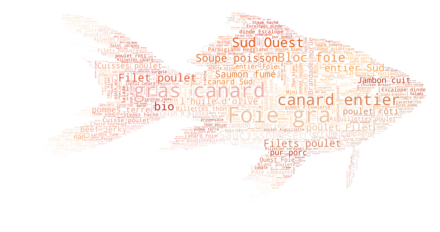

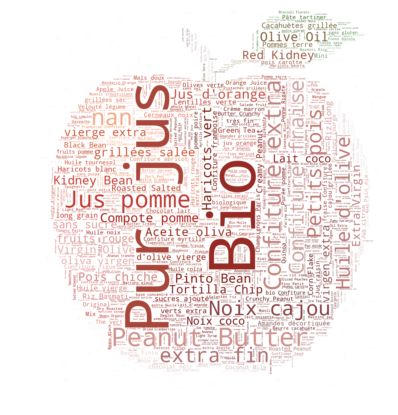

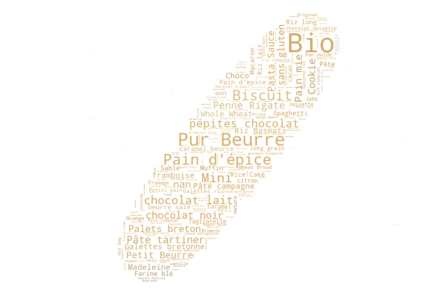

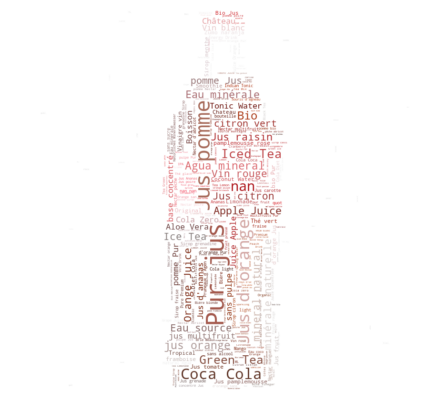

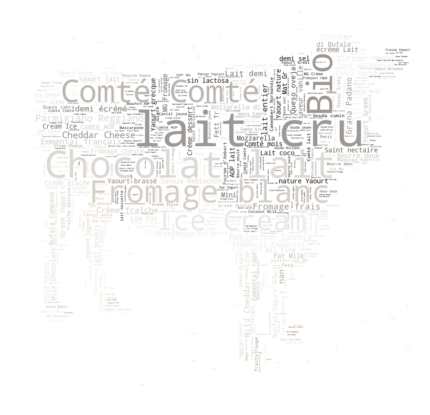

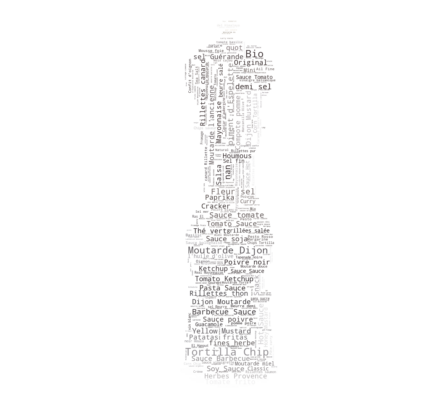

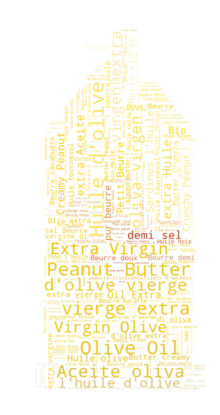

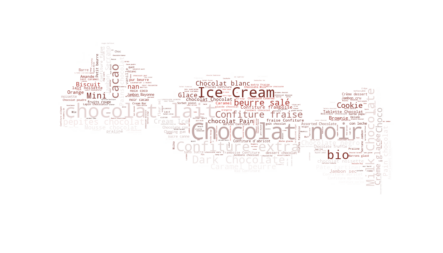

In [35]:
# Defining the list of image names taken for wordcloud 
image_path="images/"
images_names=["fish.png","apple.jpg","pain.png","drink.jpg","cow.jpg","cooking.jpg","huile.png","sweet.jpg"]

# Listing the categories
category_list = list(parent_categories_df_dict.keys())

# Creating word cloud for each image with the corresponding category i.e fish.png --> meat
for index,category in enumerate(category_list):
    image = (Image.open(image_path+images_names[index]))
    image=np.array(image.convert('RGBA'))
    df = parent_categories_df_dict[category]
    words = ' '.join(df['product_name'].astype(str).values)
    create_wordcloud(words, image=image, save_path=image_path+images_names[index][:-4]+"_wc.png")

### Plot of categories wordclouds

We merge all the previous images into one using an external program (Krita) and then plot the final image using plotly, to be able to zoom into it.

In [6]:
scale_factor = 1.0
local_image_path = 'images/wordcloud_categories.png'

# We need to put this URL in the plot so that it is displayed in the datastory
remote_image_url = 'https://antoineweber.github.io/ADA_Project_RobAda/images/wordcloud_categories.png'
image_width, image_height = np.array(Image.open(local_image_path)).shape[0:2]

fig = go.Figure()

# add invisible trace
fig.add_trace(
    go.Scatter(
        x=[0, image_width * scale_factor],
        y=[0, image_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

fig.add_layout_image(go.layout.Image(
        x=0,
        sizex=image_width * scale_factor,
        y=image_height * scale_factor,
        sizey=image_height * scale_factor,
        xref='x',
        yref='y',
        opacity=1.0,
        layer='below',
        sizing='stretch',
        source=remote_image_url))

fig.update_layout(
    title=dict(text='Wordcloud of product categories',
    xanchor= 'center',
    yanchor= 'top',
    x = 0.5,
    y = 0.95),
    autosize=False,
    width=700,
    height=700,
    plot_bgcolor='rgba(0,0,0,0)')

# Remove axis
fig.update_xaxes(
    visible=False,
    range=[0, image_width * scale_factor]
)

fig.update_yaxes(
    visible=False,
    range=[0, image_height * scale_factor]
)

# Disable the autosize on double click because it adds unwanted margins around the image
fig.show(config={'doubleClick': 'reset'})

In [25]:
generate_url(fig, 'category_wordcloud', auto_open=False)

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~inutile/36.embed" height="525" width="100%"></iframe>
